In [1]:
# import scanpy as sc
# adata_t1 = sc.read_h5ad("/home/jrich/data/varseek_data/sequencing/bulk/ccle/ccle_data_out_medium_nov18/RNASeq__253JBV_URINARY_TRACT___SAMN10987963___SRX5414883___SRR8616167/kb_count_out_mutation_index/counts_unfiltered")

# import sys
# import importlib

# # Remove the module from sys.modules
# if 'varseek.clean' in sys.modules:
#     del sys.modules['varseek.clean']

# # Import the module and reload it
# import varseek.varseek_clean
# importlib.reload(varseek.varseek_clean)
# import varseek as vk

# adata_t1_clean = vk.varseek_clean.clean(adata_t1, adata_output_path = "./temp.h5ad", minimum_count_filter = 2, use_binary_matrix = False, technology = "bulk", do_cpm_normalization = False, split_reads_by_Ns_and_low_quality_bases = False)

# Medium test:
lineage_subtype OR subtype_disease
- NSCLC
- melanoma
- colorectal_adenocarcinoma
- ovary_adenocarcinoma
- Ductal Adenocarcinoma, exocrine
- gastric_adenocarcinoma
- upper_aerodigestive_squamous
- hepatocellular_carcinoma
- bladder_carcinoma
- renal_cell_carcinoma


In [2]:
import os
import varseek as vk
import scanpy as sc
import numpy as np
import pandas as pd
import json
import scipy.sparse as sp
from sklearn.metrics import adjusted_rand_score
from anndata import concat

from varseek.utils import create_mutated_gene_count_matrix_from_mutation_count_matrix, plot_items_descending_order, plot_scree, plot_loading_contributions, find_resolution_for_target_clusters, plot_contingency_table, plot_knn_tissue_frequencies, plot_ascending_bar_plot_of_cluster_distances, plot_jaccard_bar_plot, safe_literal_eval
number_of_cancer_types = 10  #!!! change to 38

def get_tissue_name_from_experiment_alias(experiment_alias_underscores_only):
    experiment_alias_underscores_only_without_rnaseq_list = experiment_alias_underscores_only.split("__")
    experiment_alias_underscores_only_without_rnaseq_string = "_".join(experiment_alias_underscores_only_without_rnaseq_list[1:])
    tissue_list = experiment_alias_underscores_only_without_rnaseq_string.split("_")[1:]
    tissue_string = "_".join(tissue_list)
    return tissue_string

CCLE has 38 cancer types and 1019 cell lines

In [ ]:
minimum_count_filter = 2  # anything below this will be set to 0
split_reads_by_Ns_and_low_quality_bases = False
use_binary_matrix = False
do_cpm_normalization = False
tolerance=3  # tolerance in diff between number of leiden clusters and number of cancer types
n_comps = 50  # number of PCs
matrix_type = "mutation"  # mutation or gene
sum_strategy = "total_reads"  # only if matrix_type is gene
merge_strategy = "all"  # only if matrix_type is gene

mutation_metadata_df_path = "/home/jrich/data/varseek_data_fresh/vk_build_pipeline_t2t_nov16/variants_updated_filtered.csv"
mutation_metadata_df_columns = ["vcrs_id", "vcrs_header", "gene_name", "header_with_gene_name"]  #* change usecols as desired
base_dir = "/home/jrich/data/varseek_data/sequencing/bulk/ccle"
ccle_data_out_dir = os.path.join(base_dir, "ccle_data_out_medium_nov18")  #!!! change to ccle_data_out_nov19
json_metadata_path = "/home/jrich/data/varseek_data/sequencing/bulk/ccle/ccle_metadata_medium_best.json"  #!!! change to ccle_metadata_updated.json

In [ ]:
plot_dir = os.path.join(base_dir, "plots")

adata_out_path = f"{base_dir}/adata_combined_ccle_rnaseq_{matrix_type}.h5ad"
adata_grouped_tissue_out_path = f"{base_dir}/adata_combined_ccle_rnaseq_{matrix_type}_grouped_tissue.h5ad"

count_column = "vcrs_count" if (matrix_type == "mutation" or sum_strategy != "unique_mutations") else "gene_count"

In [5]:
mutation_metadata_df = pd.read_csv(mutation_metadata_df_path, usecols = mutation_metadata_df_columns)

with open(json_metadata_path, 'r') as file:
    json_data = json.load(file)

# Convert JSON to DataFrame
json_df = pd.DataFrame(json_data)

1. Load in matrix after preprocessing
2. Combine each cancer type row into one matrix
3. re-plot the top n mutations for each cancer type in descending line plots with expression as y axis (or even just lists)
4. Run PCA on the combined matrix - make PCA plot, Scree plot, loadings plot (which mutations contributed to the major PCs)
5. Plot heatmap of mutation expression (or some other value) for each mutation (x) and sample i.e., cancer type (y) eg seaborn

In [6]:
import sys
import importlib

# Remove the module from sys.modules
if 'varseek.clean' in sys.modules:
    del sys.modules['varseek.clean']

# Import the module and reload it
import varseek.varseek_clean
importlib.reload(varseek.varseek_clean)
import varseek as vk

# instead of using vk.build() as before, I must explicitely use vk.varseek_build.build()

In [7]:
# adata = adata_copy.copy()

In [ ]:
adata_list = []
for study in os.listdir(ccle_data_out_dir):
    if study == "multiqc_total_data" or study == "multiqc_total.html":
        continue
    full_path = os.path.join(ccle_data_out_dir, study)
    experiment_alias_underscores_only, sample_accession, experiment_accession, run_accession = study.split("___")
    tissue = get_tissue_name_from_experiment_alias(experiment_alias_underscores_only)
    kb_count_out_mutation_index_dir = os.path.join(full_path, "kb_count_out_mutation_index")
    kb_count_out_standard_index_dir = os.path.join(full_path, "kb_count_out_standard_index")

    adata_mutation_path = f"{kb_count_out_mutation_index_dir}/counts_unfiltered/adata.h5ad"
    adata_output_path = f"{kb_count_out_mutation_index_dir}/counts_unfiltered/adata_cleaned.h5ad"

    adata_mutation = sc.read_h5ad(adata_mutation_path)
    adata_mutation.obs_names = [f"{experiment_accession}_{tissue}"] * adata_mutation.n_obs  #!! the * adata_mutation.n_obs is new as of 12/2/24


    adata_mutation.obs["sample_accession"] = sample_accession
    adata_mutation.obs["experiment_accession"] = experiment_accession
    adata_mutation.obs["run_accession"] = run_accession
    adata_mutation.obs["experiment_alias_underscores_only"] = experiment_alias_underscores_only
    adata_mutation.obs["tissue"] = tissue

    adata_mutation = vk.varseek_clean.clean(adata_mutation, adata_output_path = adata_output_path, minimum_count_filter = minimum_count_filter, use_binary_matrix = use_binary_matrix, technology = "bulk", do_cpm_normalization = do_cpm_normalization, split_reads_by_Ns_and_low_quality_bases = split_reads_by_Ns_and_low_quality_bases)
    if 'vcrs_count' in adata_mutation.var.columns:
        adata_mutation.var.drop('vcrs_count', axis=1, inplace=True)

    adata_list.append(adata_mutation)

adata = concat(adata_list, join='outer')

adata.obs = adata.obs.merge(
    json_df[['experiment_accession', 'library_strategy', 'primary_disease', 
             'subtype_disease', 'sex', 'age', 'lineage_subtype', 
             'Cellosaurus_NCIt_disease', 'lineage']],
    on='experiment_accession', 
    how='left'
)

# prevents the error "Don’t call _normalize_index with non-categorical/string names" when trying adata = adata[:, nonzero_gene_mask]
adata.obs.index = adata.obs.index.astype(str)

if use_binary_matrix:
    adata.X = (adata.X > 0).astype(int)

adata.var['vcrs_id'] = adata.var.index
original_var_names = adata.var_names.copy()
# merge adata.var with mutation_metadata_df by vcrs_id
adata.var = adata.var.merge(mutation_metadata_df, on='vcrs_id', how='left')
adata.var_names = original_var_names

ncomps_temp = min(n_comps, adata.shape[0]-1, adata.shape[1]-1)
n_comps = ncomps_temp

adata.var["vcrs_count"] = adata.X.sum(axis=0).A1 if hasattr(adata.X, "A1") else np.asarray(adata.X.sum(axis=0)).flatten()  
adata.var = adata.var.copy()  # avoids warning
adata.var["gene_name"] = adata.var["gene_name"].astype('object')  # converts from category to object
adata.var["gene_name"] = adata.var["gene_name"].apply(safe_literal_eval)  # converts list-like string to list
adata.var["gene_name_set"] = adata.var['gene_name'].apply(lambda x: sorted(set(x)))
adata.var['gene_name_set_string'] = adata.var['gene_name_set'].apply(lambda x: ';'.join(x))  # converts list to semi-colon joined string

# print(type(adata.X))  # Should be a sparse matrix type if stored that way in the originals
# print(adata.X.shape)   # Should show (1019, 5.3M)
# print(adata.obs.head())
# print(adata.var.head())
print(adata)

AnnData object with n_obs × n_vars = 50 × 5241651
    obs: 'sample_accession', 'experiment_accession', 'run_accession', 'experiment_alias_underscores_only', 'tissue', 'library_strategy', 'primary_disease', 'subtype_disease', 'sex', 'age', 'lineage_subtype', 'Cellosaurus_NCIt_disease', 'lineage'
    var: 'vcrs_id', 'vcrs_header', 'gene_name', 'header_with_gene_name', 'vcrs_count', 'gene_name_set', 'gene_name_set_string'


In [9]:
if matrix_type == "gene":
    adata_mutation = adata.copy()
    adata = create_mutated_gene_count_matrix_from_mutation_count_matrix(adata, sum_strategy = sum_strategy, merge_strategy = merge_strategy, use_binary_matrix=use_binary_matrix)

## Drop 0 columns

In [10]:
# Identify columns (genes) with non-zero counts across samples
nonzero_gene_mask = np.array((adata.X != 0).sum(axis=0)).flatten() > 0

# Filter the AnnData object to keep only genes with non-zero counts across samples
adata = adata[:, nonzero_gene_mask]

# Check the new shape to confirm columns were removed
print(adata.shape)  # Should be (1019, <=5.3M)

(50, 815640)


In [ ]:
# heatmap
# 6 x 46
# row: number of samples of cancer type X possessing a mutation
# column: number of samples a different cancer type possessing a mutation
# value: number of mutations in this category

## Perform PCA

[[   6.8070436  128.95958   -343.05612   ...    1.191898    -4.483365
    -1.6824962]
 [ -47.944286   -33.47778    -18.611261  ...   -8.271506    -3.2348182
   -10.539369 ]
 [  13.223973    31.612083   -16.88629   ...    2.034098    -7.737303
    -4.0456705]
 ...
 [  63.684937   -14.642384     1.2661954 ...    1.4686133   -8.555672
    -2.4461927]
 [ -31.095646    -5.049742   -26.767157  ...   -6.301084    -5.1891074
    -6.759097 ]
 [ -55.152435   -31.276743    -9.27018   ...   -1.0715611   -3.5445032
    -4.40859  ]]
[0.0409546  0.03626684 0.03419145 0.03348904 0.02960472 0.02857993
 0.02742342 0.02698945 0.02626617 0.02601093 0.02537135 0.0248579
 0.0242254  0.02394035 0.02337981 0.022819   0.02267986 0.02221846
 0.02206165 0.02163967 0.02154027 0.02056921 0.0197667  0.01961097
 0.01915464 0.01891104 0.01861566 0.01847267 0.01843008 0.01817819
 0.01753214 0.01716788 0.01651536 0.01597022 0.01580087 0.01514914
 0.01458494 0.01444039 0.01409809 0.01392756 0.01383118 0.01366232
 0.0136

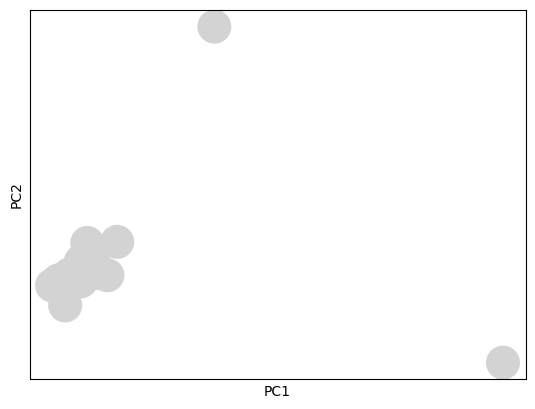

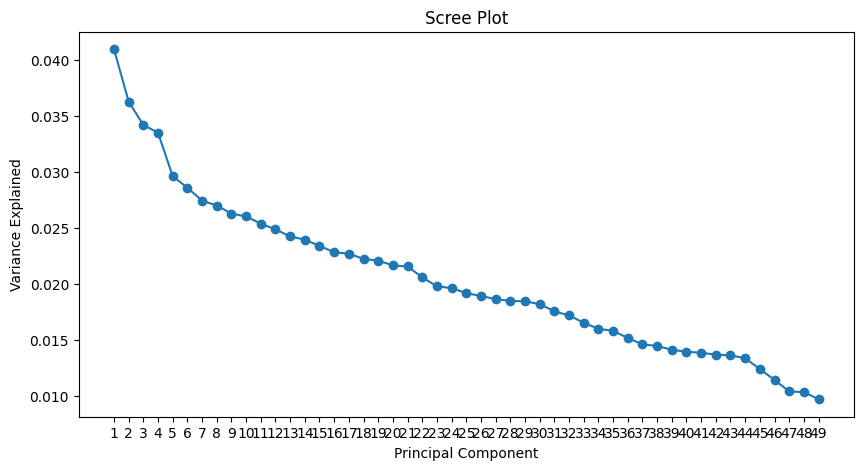

/home/jrich/Desktop/varseek/varseek/utils/visualization_utils.py:850: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_copy, resolution=resolution)


Iteration 1: Resolution = 5.05, Clusters = 50
Iteration 2: Resolution = 2.5749999999999997, Clusters = 47
Iteration 3: Resolution = 1.3375, Clusters = 17
Iteration 4: Resolution = 0.71875, Clusters = 1
Iteration 5: Resolution = 1.028125, Clusters = 4
Iteration 6: Resolution = 1.1828124999999998, Clusters = 11
Optimal resolution for ~10 clusters: 1.1828124999999998 (yielded 11 clusters)


In [11]:
adata.layers["counts"] = adata.X.copy()

# Log-transform the data
sc.pp.log1p(adata)

# Scale the data
sc.pp.scale(adata)

adata.layers["logged_scaled_counts"] = adata.X.copy()

# Run PCA, specifying the number of components
sc.tl.pca(adata, n_comps=n_comps)

# Sample scores on the first few principal components
print(adata.obsm["X_pca"])

# Explained variance for each component
print(adata.uns["pca"]["variance_ratio"])

# plot PCA
pca_plot_dir = f"{plot_dir}/pca_plot"
os.makedirs(pca_plot_dir, exist_ok=True)
pca_fig = sc.pl.pca(adata, return_fig=True)
pca_fig.savefig(f"{pca_plot_dir}/pca.png", dpi=300)
plot_scree(adata, output_plot_file=f"{pca_plot_dir}/scree.png")  # scree plot   # sc.pl.pca_variance_ratio(adata, n_pcs=n_comps, log=True)

for pc_index in range(n_comps):
    pca_plot_dir_pc_specific = f"{pca_plot_dir}/loading_{pc_index}"
    os.makedirs(pca_plot_dir_pc_specific, exist_ok=True)
    plot_loading_contributions(adata, PC_index = pc_index, top_genes_stats = 100, top_genes_plot = 10, output_stats_file = f"{pca_plot_dir_pc_specific}/top_genes_stats.txt", output_plot_file=f"{pca_plot_dir_pc_specific}/loadings.png")

# knn, clustering, alluvial
sc.pp.neighbors(adata, n_neighbors=15)

adata, resolution, num_clusters = find_resolution_for_target_clusters(adata, target_clusters=number_of_cancer_types, tolerance=tolerance)
print(f"Optimal resolution for ~{number_of_cancer_types} clusters: {resolution} (yielded {num_clusters} clusters)")

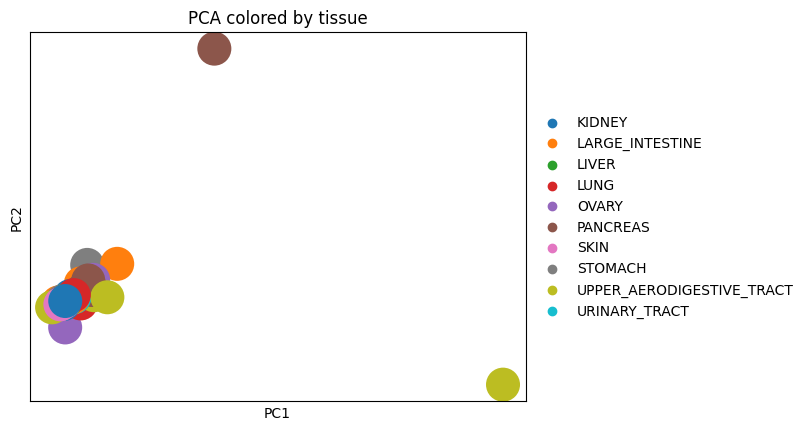

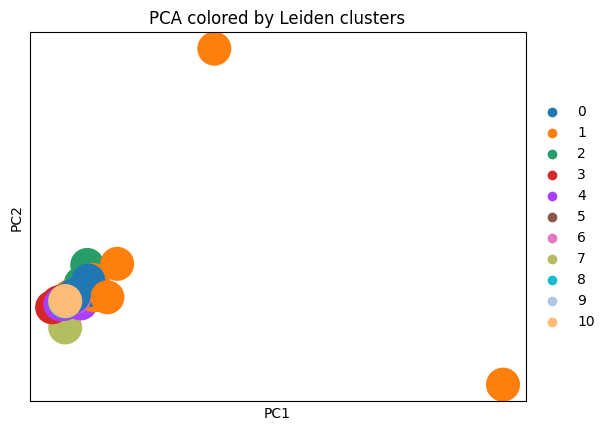

In [12]:
pca_fig = sc.pl.pca(adata, color='tissue', title="PCA colored by tissue", return_fig=True)
pca_fig.savefig(f"{pca_plot_dir}/pca_tissue.png", dpi=300)
pca_fig = sc.pl.pca(adata, color='leiden', title="PCA colored by Leiden clusters", return_fig=True)
pca_fig.savefig(f"{pca_plot_dir}/pca_leiden.png", dpi=300)

In [13]:
adata.uns['tissue_leiden_ari'] = adjusted_rand_score(adata.obs['tissue'], adata.obs['leiden'])
print(f"Adjusted Rand Index (ARI) between 'leiden' and 'tissue': {adata.uns['tissue_leiden_ari']}")

Adjusted Rand Index (ARI) between 'leiden' and 'tissue': 0.07179390035991665


### Simulate values of ARI to calculate p-value

In [ ]:
#!!! NEW

# Extract true labels and predicted labels
true_labels = adata.obs['tissue']
predicted_labels = adata.obs['leiden']
observed_ari = adjusted_rand_score(true_labels, predicted_labels)

# Generate a null distribution of ARIs
n_permutations = 1000  # Number of permutations
null_ari = []

for _ in range(n_permutations):
    # Randomly permute the 'leiden' labels
    permuted_labels = np.random.permutation(predicted_labels)
    # Compute the ARI for the permuted labels
    null_ari.append(adjusted_rand_score(true_labels, permuted_labels))

# Convert to a numpy array for easier manipulation
null_ari = np.array(null_ari)

# Calculate the p-value
p_value = (null_ari >= observed_ari).sum() / n_permutations

# Display results
print(f"Observed ARI: {observed_ari}")
print(f"Mean of null ARI: {np.mean(null_ari)}")
print(f"P-value: {p_value}")

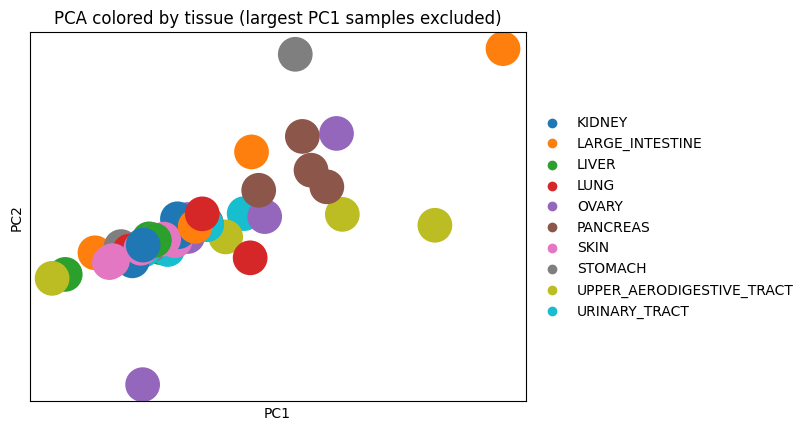

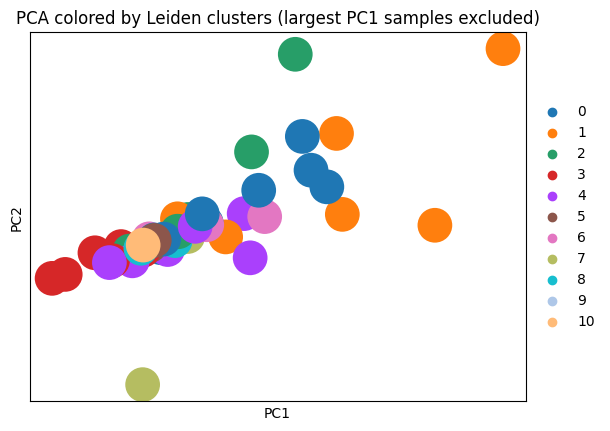

In [14]:
# Step 1: Extract PC1 values
pc1_values = adata.obsm["X_pca"][:, 0]

# Step 2: Identify indices of the 2 largest PC1 values
largest_pc1_indices = pc1_values.argsort()[-2:]  # Indices of the 2 largest values

# Step 3: Create a mask to exclude these samples
mask = ~np.isin(range(adata.n_obs), largest_pc1_indices)

# Step 4: Filter the AnnData object
adata_filtered = adata[mask, :]

# Step 5: Plot the filtered data
pca_fig = sc.pl.pca(
    adata_filtered,
    color='tissue',
    title="PCA colored by tissue (largest PC1 samples excluded)",
    return_fig=True
)

pca_fig = sc.pl.pca(
    adata_filtered,
    color='leiden',
    title="PCA colored by Leiden clusters (largest PC1 samples excluded)",
    return_fig=True
)

In [15]:
# neighbornet - see Tara's paper - https://github.com/pachterlab/CP_2021

from scipy.spatial.distance import pdist, squareform

distance_metric = "hamming" if use_binary_matrix else "euclidean"
adata.uns["distance_matrix"] = squareform(pdist(adata.obsm["X_pca"], metric=distance_metric))  # should be of shape (PCA, PCA)

#!!! insert Tara's code

In [16]:
adata_obs_csv = f"{base_dir}/adata_obs.csv"
# adata.obs[['tissue', 'leiden', 'experiment_accession']].to_csv(adata_obs_csv, index=False)

r_script = f"{os.path.dirname(os.getcwd())}/scripts/alluvial_code.R"
column1 = "tissue"
column2 = "leiden"
show_group_2_box_labels_in_ascending = False
alluvial_output_path = f"{plot_dir}/alluvial_plot.png"  # default "./alluvial_plot.png"

command = ["Rscript", r_script, "--input_csv", adata_obs_csv, "--column1", column1, "--column2", column2]

if alluvial_output_path:
    command.extend(["--output_path", alluvial_output_path])

if show_group_2_box_labels_in_ascending:
    command.append("--show_group_2_box_labels_in_ascending")

print("Download adata_obs.csv, change rscript path and adata_obs.csv path and out path, and run the following command in terminal:")
print(" ".join(command))

# import subprocess
# try:
#     subprocess.run(command)
# except Exception as e:
#     print(f"Running the alluvial plot-generating R script failed. Note that this script requires a valid installation of R and the following packages: optparse, tidyverse, ggforce, ggalluvial, extrafont.\nError while running R script: {e}")

Download adata_obs.csv, change rscript path and adata_obs.csv path and out path, and run the following command in terminal:
Rscript /home/jrich/Desktop/varseek/scripts/alluvial_code.R --input_csv /home/jrich/data/varseek_data/sequencing/bulk/ccle/adata_obs.csv --column1 tissue --column2 leiden --output_path /home/jrich/data/varseek_data/sequencing/bulk/ccle/plots/alluvial_plot.png


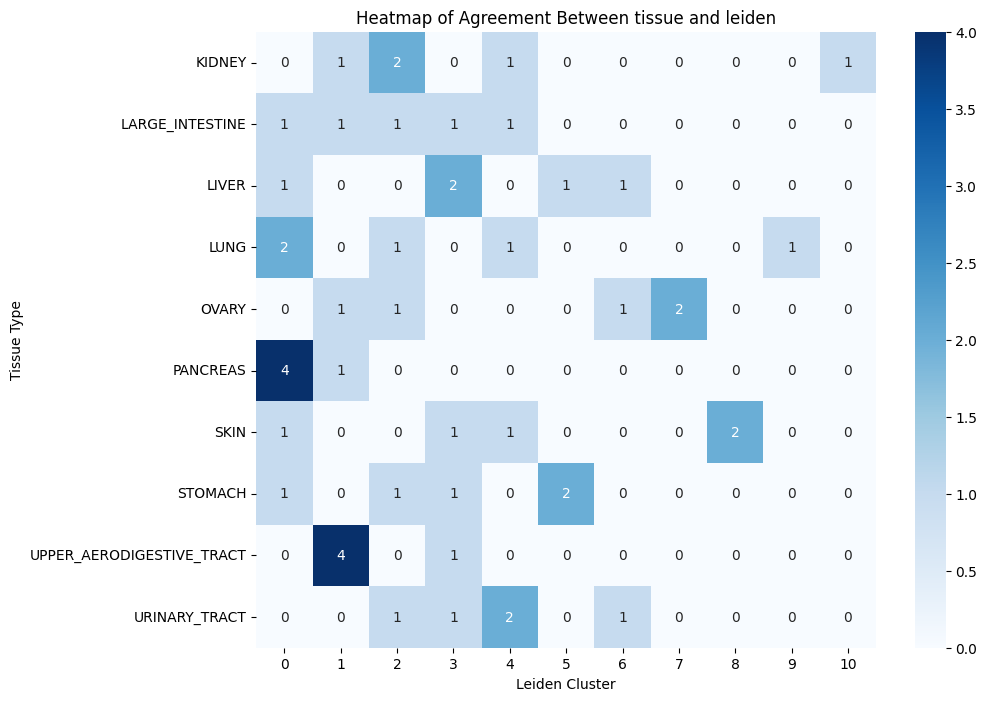

In [17]:
plot_contingency_table(adata, column1 = "tissue", column2 = "leiden", output_plot_file=f"{plot_dir}/contingency_table.png")  #* consider replacing with my alluvial plot

In [ ]:
adata.X = adata.layers["counts"].copy()  # undo to log1p and scale

adata.var['gene_name'] = adata.var['gene_name'].apply(str)  # Convert gene_name to string to avoid error when saving adata
adata.var['gene_name_set'] = adata.var['gene_name_set'].apply(str)  # Convert gene_name to string to avoid error when saving adata

In [20]:
grouped_tissue_dir = f"{base_dir}/grouped_tissue"

adata_tissue_specific_list = []

# Iterate through each unique tissue type
for tissue in adata.obs['tissue'].unique():
    specific_tissue_dir = f"{grouped_tissue_dir}/{tissue}"
    os.makedirs(specific_tissue_dir, exist_ok=True)

    # Subset adata for the current tissue
    tissue_adata_temp = adata[adata.obs['tissue'] == tissue].copy()
    
    # Sum the matrix across rows (cells) for this tissue, resulting in a 1-row array
    summed_matrix = tissue_adata_temp.X.sum(axis=0)  # Sum across rows for each column

    if not sp.issparse(summed_matrix):
        summed_matrix = sp.csr_matrix(summed_matrix)  # Convert to sparse if not already

    if type(summed_matrix) == np.ndarray:
        summed_matrix = summed_matrix.reshape(1, -1)

    # Create a new adata object with a single row containing the summed values
    adata_tissue_specific = sc.AnnData(summed_matrix, var=tissue_adata_temp.var)
    
    # Update the 'obs' for this single-row adata to reflect the tissue type
    adata_tissue_specific.obs_names = [tissue]
    adata_tissue_specific.obs['tissue'] = [tissue]
    adata_tissue_specific.obs['number_of_samples'] = [len(tissue_adata_temp)]

    adata_tissue_specific.var[count_column] = adata_tissue_specific.X.sum(axis=0).A1 if hasattr(adata_tissue_specific.X, "A1") else np.asarray(adata_tissue_specific.X.sum(axis=0)).flatten()  

    adata_tissue_specific.var = adata_tissue_specific.var.sort_values(by=count_column, ascending=False)

    sorted_mutations_file = f"{specific_tissue_dir}/sorted_mutations.txt"
    with open(sorted_mutations_file, "w") as f:
        for mutation_name, count in zip(adata_tissue_specific.var['header_with_gene_name'], adata_tissue_specific.var[count_column]):
            f.write(f"{mutation_name} {count}\n")

    plot_items_descending_order(adata_tissue_specific.var, x_column = 'header_with_gene_name', y_column = count_column, item_range = (0,100), xlabel = "Mutation", title = "Top 100 Mutations by VCRS Count", save_path = f'{specific_tissue_dir}/top_100_mutations_plot.png', figsize = (15, 7))
    plot_items_descending_order(adata_tissue_specific.var, x_column = 'header_with_gene_name', y_column = count_column, item_range = (0,1000), xlabel = "Mutation Index", title = "Top 1000 Mutations by VCRS Count", save_path = f'{specific_tissue_dir}/top_1000_mutations_plot.png', figsize = (15, 7))

    combined_gene = adata_tissue_specific.var.groupby('gene_name_set_string', as_index=False)[count_column].sum()
    combined_gene = pd.merge(combined_gene, adata_tissue_specific.var[['gene_name_set_string']], on='gene_name_set_string', how='left')
    combined_gene = combined_gene.drop_duplicates(subset='gene_name_set_string', keep='first')
    adata_tissue_specific.uns['combined_genes'] = combined_gene.sort_values(by=count_column, ascending=False)

    sorted_mutated_genes_file = f"{specific_tissue_dir}/sorted_mutated_genes.txt"
    with open(sorted_mutated_genes_file, "w") as f:
        for gene_name, count in zip(adata_tissue_specific.uns['combined_genes']['gene_name_set_string'], adata_tissue_specific.uns['combined_genes'][count_column]):
            f.write(f"{gene_name} {count}\n")

    plot_items_descending_order(adata_tissue_specific.uns['combined_genes'], x_column = 'gene_name_set_string', y_column = count_column, item_range = (0,100), xlabel = "Gene", title = "Top 100 Genes by VCRS Count", save_path = f'{specific_tissue_dir}/top_100_genes_plot.png', figsize = (15, 7))

    adata_tissue_specific_list.append(adata_tissue_specific)

adata_tissue_grouped = concat(adata_tissue_specific_list, join='outer')

adata_tissue_grouped.var = pd.merge(
    adata_tissue_grouped.var,
    adata.var,
    left_index=True,
    right_index=True,
    how="left"  # Use "left" to keep only indices from adata_tissue_grouped.var
)

In [30]:
adata.write(adata_out_path)
adata_tissue_grouped.write(adata_grouped_tissue_out_path)

In [ ]:
#!! for each cancer type, split into 2/3 1/3 and train a ML model to predict the cancer type
#!! take just variant matrix and try to predict cancer type; and similarly do by normal sample x mutation matrix (and compare to sample x mutation matrix)